# Plot a comparison of properties

### Import python modules (install these if you dont have them)

In [1]:
#External Python Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import importlib

#Add 'functions' folder to notebook directory
cwd = os.getcwd()
fn_dir = cwd + '/functions'
sys.path.append(fn_dir)

#Functions in 'functions' folder
import fn_sql
import fn_doi2bib
import fn_insert
import fn_getfile
import fn_db

### Initiate database connection

In [2]:
db_connection = {
    'address' : 'dfn-parameters.postgres.database.azure.com',
    'port' : '5432',
    'username' : 'testuser@dfn-parameters',
    'password' : 'testuserpassword',
    'dbname' : 'dfndb',
}

db_connection = fn_sql.sqlalchemy_connect(db_connection) #Make connection
dfndb = db_connection['dbobject']

### 1. Plot a query of a single property:

Here we find a SINGLE PROPERTY - the transference number of an FEC containing electrolyte, from the Landesfeind paper

In [3]:
#Query the data id
QUERY = '''
        SELECT DISTINCT data.data_id,parameter.name, material.name, paper.paper_tag, data.temp_range, data.function
        FROM data
        JOIN paper ON paper.paper_id = data.paper_id
        JOIN material ON material.material_id = data.material_id
        JOIN parameter ON parameter.parameter_id = data.parameter_id
        WHERE parameter.name = 'Transference Number'
        AND 
        material.fec != 0
        AND
        paper.paper_tag = 'Landesfeind2019';
        '''
df = pd.read_sql(QUERY,dfndb)
df

,data_id,name,name,paper_tag,temp_range,function
0,118,Transference Number,LiPF6:EMC:FEC 19:1,Landesfeind2019,"[263, 323]","[b'\n', b'd', b'e', b'f', b' ', b'f', b'u', b'..."


raw_data is function
parameter_from_db.py downloaded


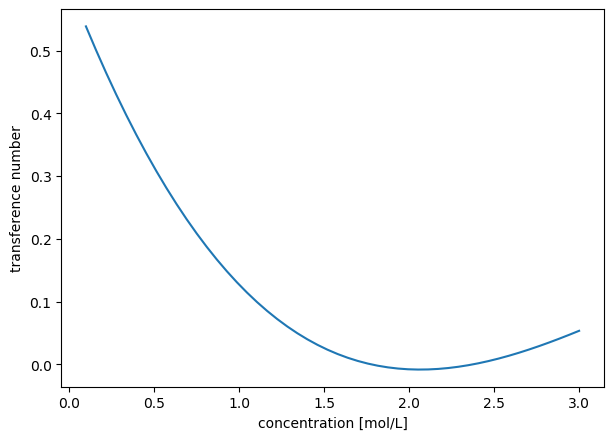

In [4]:
#Query the property back
QUERY = 'SELECT * FROM data WHERE data_id = 118;'
df = pd.read_sql(QUERY,dfndb)

csv_list = fn_db.read_data(df) 
#Reads the first row of a complete data-table pandas dataframe
#outputs a CSV as a python list if it exists (for transference it does not)
#writes the function file in the current directory as 'parameter_from_db.py'\

import parameter_from_db #import/reload parameter_from_db.py file
importlib.reload(parameter_from_db)

#Plot the data

c_e = np.linspace(100,3000) #SI Units mol/m3
T = 298 # K
tp = parameter_from_db.function(c_e,T) #run the function just written from the database

x = c_e/1000
y = tp
w = 7
h = 5
d = 100
plt.figure(figsize=(w, h), dpi=d)
plt.plot(x,y)
plt.ylabel('transference number')
plt.xlabel('concentration [mol/L]')
plt.show()

### 2. Loop to compare solid diffusivities reported for graphite at room temperature

In [8]:
#Query out the properties
QUERY = '''
        SELECT data.data_id, parameter.name, material.name, paper.paper_tag,data.input_range, data.temp_range, method.name, data.function
        FROM data
        JOIN paper ON paper.paper_id = data.paper_id
        JOIN material ON material.material_id = data.material_id
        JOIN parameter ON parameter.parameter_id = data.parameter_id
        JOIN data_method ON data_method.data_id = data.data_id
        JOIN method ON method.method_id = data_method.method_id
        WHERE parameter.name = 'Diffusion Coefficient'
        AND
        material.class = 'anode'
        AND 
        298 BETWEEN lower(data.temp_range) AND upper(data.temp_range);
        '''
df = pd.read_sql(QUERY,dfndb)
df

,data_id,name,name,paper_tag,input_range,temp_range,name,function
0,74,Diffusion Coefficient,graphite,Schmalstieg2018,"[0, 1]","[250, 313]",GITT,None
1,69,Diffusion Coefficient,graphite,Ecker2015,"[0, 1]","[250, 333]",GITT,None
2,72,Diffusion Coefficient,graphite,Ecker2015,"[0, 1]","[250, 333]",EIS,None


In [9]:
csv_list = fn_db.read_data(diff_df) 

raw_data is array
<class 'NoneType'>


raw_data is array
<class 'NoneType'>
raw_data is array
<class 'NoneType'>
raw_data is array
<class 'NoneType'>


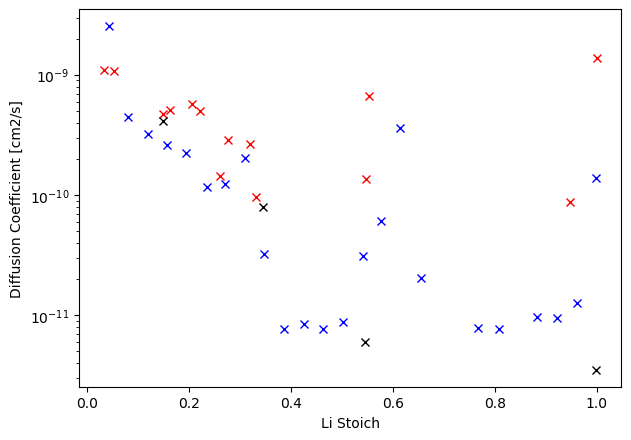

In [11]:
#Plot it out
T = 298
id_list = df['data_id'].to_list()
w = 7
h = 5
d = 100
color_array = ['red','blue','black','green']
plt.figure(figsize=(w, h), dpi=d)

for i in range(len(id_list)):
    data_id = id_list[i]
    c = color_array[i]
    QUERY = 'SELECT * FROM data WHERE data_id = %s;' %str(data_id)
    diff_df = pd.read_sql(QUERY,dfndb)
    csv_list = fn_db.read_data(diff_df) 
    x_csv = np.array(csv_list)[:,0]
    y_csv = np.array(csv_list)[:,1]
    plt.plot(x_csv,y_csv*10000,'x',color=c)
    
plt.ylabel('Diffusion Coefficient [cm2/s]')
plt.xlabel('Li Stoich')
plt.yscale('log')
plt.show()

### 3. Loop to compare material OCPs

In [12]:
#Query out the properties
QUERY = '''
        SELECT data.data_id, parameter.name, material.name, paper.paper_tag,data.input_range, data.temp_range, method.name, data.function
        FROM data
        JOIN paper ON paper.paper_id = data.paper_id
        JOIN material ON material.material_id = data.material_id
        JOIN parameter ON parameter.parameter_id = data.parameter_id
        JOIN data_method ON data_method.data_id = data.data_id
        JOIN method ON method.method_id = data_method.method_id
        WHERE parameter.name = 'Half Cell OCV'
        AND
        material.class = 'cathode';
        '''
df = pd.read_sql(QUERY,dfndb)
df

,data_id,name,name,paper_tag,input_range,temp_range,name,function
0,129,Half Cell OCV,NMC811,Chen2020,"[0, 1]","[NaN, NaN]",GITT,"[b'\n', b'd', b'e', b'f', b' ', b'f', b'u', b'..."
1,129,Half Cell OCV,NMC811,Chen2020,"[0, 1]","[NaN, NaN]",Quasi OCV,"[b'\n', b'd', b'e', b'f', b' ', b'f', b'u', b'..."
2,3,Half Cell OCV,NCO46,Ecker2015,"[0, 1]","[296, 296]",GITT,"[b'd', b'e', b'f', b' ', b'f', b'u', b'n', b'c..."
3,52,Half Cell OCV,NMC111,Schmalstieg2018,"[0, 1]","[NaN, NaN]",GITT,"[b'd', b'e', b'f', b' ', b'f', b'u', b'n', b'c..."
4,52,Half Cell OCV,NMC111,Schmalstieg2018,"[0, 1]","[NaN, NaN]",Quasi OCV,"[b'd', b'e', b'f', b' ', b'f', b'u', b'n', b'c..."


raw_data is array
<class 'memoryview'>
parameter_from_db.py downloaded
raw_data is array
<class 'memoryview'>
parameter_from_db.py downloaded
raw_data is array
<class 'memoryview'>
parameter_from_db.py downloaded
raw_data is array
<class 'memoryview'>
parameter_from_db.py downloaded
raw_data is array
<class 'memoryview'>
parameter_from_db.py downloaded


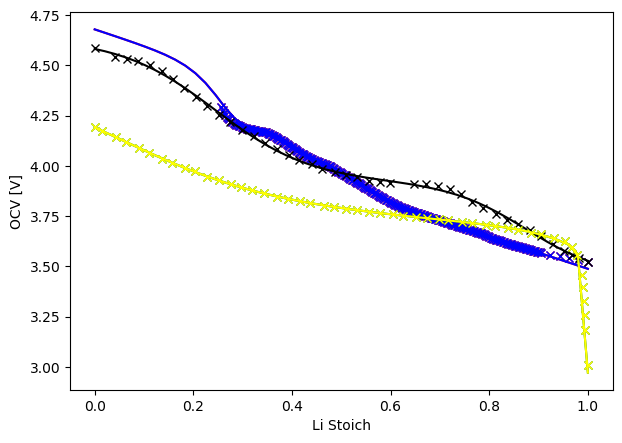

In [13]:
#Plot it out
T = 298
id_list = df['data_id'].to_list()
w = 7
h = 5
d = 100
color_array = ['red','blue','black','green','yellow']
plt.figure(figsize=(w, h), dpi=d)

for i in range(len(id_list)):
    data_id = id_list[i]
    c = color_array[i]
    QUERY = 'SELECT * FROM data WHERE data_id = %s;' %str(data_id)
    diff_df = pd.read_sql(QUERY,dfndb)
    csv_list = fn_db.read_data(diff_df) 
    x_csv = np.array(csv_list)[:,0]
    y_csv = np.array(csv_list)[:,1]

    import parameter_from_db #import/reload parameter_from_db.py file
    importlib.reload(parameter_from_db)
    xfit = np.linspace(0,1)
    yfit = parameter_from_db.function(xfit) #USE FUNCTION WITH x INPUT TO CALCULATE OCV
    plt.plot(x_csv,y_csv,'x',color=c)
    plt.plot(xfit,yfit,color=c)
plt.ylabel('OCV [V]')
plt.xlabel('Li Stoich')
plt.show()